# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [6]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)  # Moyenne mu
        self.fc22 = nn.Linear(400, 50)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
for epoch in range(10):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 168.33741640625
Epoch 1, Loss: 126.44163671875
Epoch 2, Loss: 116.98342937825521
Epoch 3, Loss: 112.77038715820312
Epoch 4, Loss: 110.54235875651041
Epoch 5, Loss: 109.08989943033855
Epoch 6, Loss: 108.09209903971355
Epoch 7, Loss: 107.3770080078125
Epoch 8, Loss: 106.7794205078125
Epoch 9, Loss: 106.31096505533854


## Exercices

* Rédiger un code Python qui permet d'échantillonner à partir de l'espace latent pour générer de nouvelles images.

Pour faire de l'inférence, nous n'avons pas besoin de faire passer le gradient à travers le processus d'échantillonnage, car nous ne faisons pas de rétropropagation.

On suppose que le modèle a été correctement entraîné et que l'espace latent suit la distribution Gaussienne. 

Donc, directement échantillonner de cette distribution sans avoir besoin de la reparamétrisation.

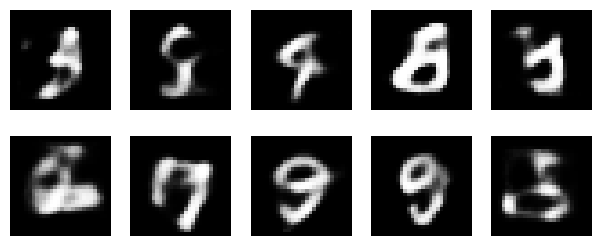

In [31]:
import matplotlib.pyplot as plt

def generate_images(vae, num_samples=10, latent_dim=50, image_size=(28, 28), images_per_row=5):
    vae.eval()

    z = torch.randn(num_samples, latent_dim).to(device)

    with torch.no_grad():
        generated_images = vae.decode(z)

    generated_images = generated_images.view(-1, *image_size)

    num_rows = num_samples // images_per_row + (0 if num_samples % images_per_row == 0 else 1)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 1.5, num_rows * 1.5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

generate_images(vae)

### Changer la dimension de l'espace latent.


In [52]:
import torch
from torch import nn
import matplotlib.pyplot as plt

#  CustomVAE avec une dimension latente à 2
class CustomVAE(nn.Module):
    def __init__(self, latent_dim=2):  # Nouvelle dimension latente
        super(CustomVAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Fonction pour afficher des images générées
def show_generated_images(vae, num_samples=10, latent_dim=100, image_size=(28, 28)):
    vae.eval()
    z = torch.randn(num_samples, latent_dim)
    with torch.no_grad():
        generated_images = vae.decode(z).view(-1, *image_size)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 1.5, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Création d'une instance du modèle CustomVAE avec la nouvelle dimension latente
custom_vae = CustomVAE(latent_dim=2)

# entraînement du modèle
optimizer = torch.optim.Adam(custom_vae.parameters(), lr=1e-3)
for epoch in range(10):
    custom_vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = custom_vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


Epoch 0, Loss: 191.81447018229167
Epoch 1, Loss: 169.19746103515624
Epoch 2, Loss: 163.72723307291668
Epoch 3, Loss: 160.35132434895834
Epoch 4, Loss: 158.26234658203126
Epoch 5, Loss: 156.69987252604167
Epoch 6, Loss: 155.4681694986979
Epoch 7, Loss: 154.45640009765626
Epoch 8, Loss: 153.6044340169271
Epoch 9, Loss: 152.86746394856772


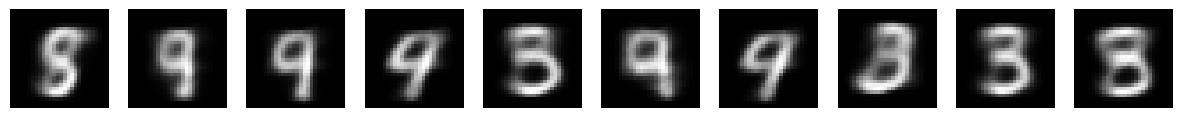

In [57]:
# Affichage des images générées
show_generated_images(custom_vae, latent_dim=2)

En effet, on remarque qu'avec une dimension de 2, nous obtenons de meilleurs résultats.  On peut penser qu'au vu du peu de complexité dans nos données, un espace latent de petite dimension peut suffire à capturer l'essentiel des variations des données. 

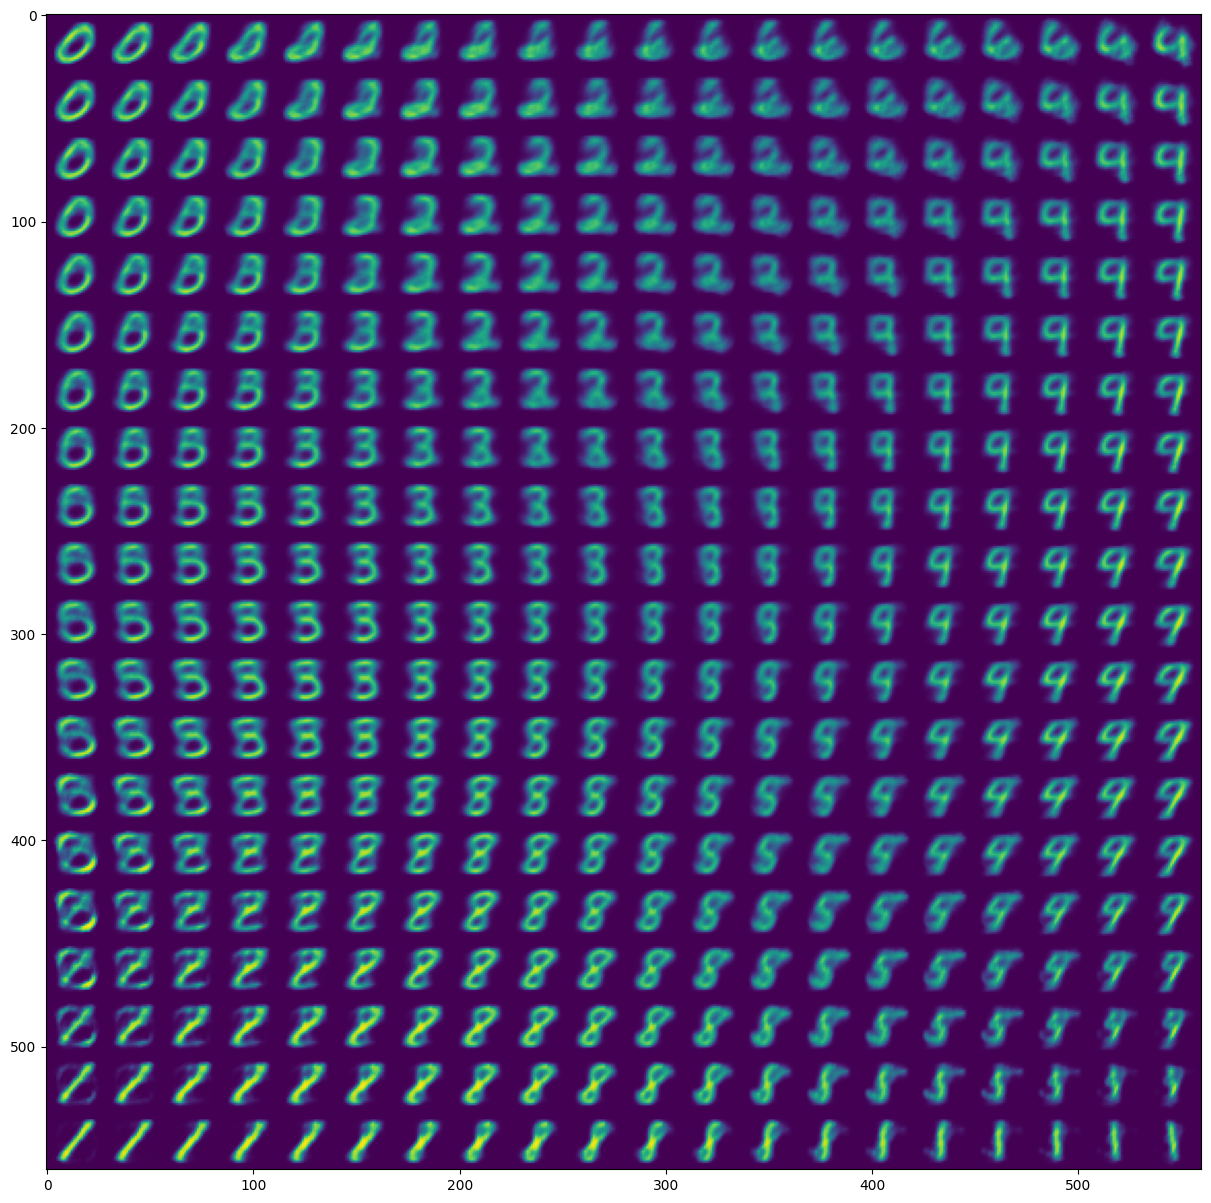

In [82]:
# Display a 2D manifold of the digits
import numpy as np
from scipy.stats import norm
n = 20  # figure with 20x20 digits
digit_size = 28

# Linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n), np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
z_grid = torch.tensor(z_grid, dtype=torch.float32).view(-1, 2).to(device)
x_decoded = custom_vae.decode(z_grid).cpu().detach().numpy()

# Display a 2D manifold of the digits
import matplotlib.pyplot as plt
from matplotlib import cm
figsize = 15
figure = np.zeros((digit_size * n, digit_size * n))
for i in range(n):
    for j in range(n):
        digit = x_decoded[i * n + j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(figsize, figsize))
plt.imshow(figure)
plt.show()

##  Changer l'architecture du VAE.

In [94]:
class ImprovedCustomVAE(nn.Module):
    def __init__(self):
        super(ImprovedCustomVAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(28 * 28, 128)  # Première couche
        self.fc21 = nn.Linear(128, 64)  # Deuxième couche
        self.fc22 = nn.Linear(64, 3)  # Moyenne mu
        self.fc23 = nn.Linear(64, 3)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(3, 64)  # Première couche du décodeur
        self.fc4 = nn.Linear(64, 128)  # Deuxième couche
        self.fc5 = nn.Linear(128, 28 * 28)  # Sortie

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc21(h1))
        return self.fc22(h2), self.fc23(h2)  # Retourne mu et logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Création d'une instance du modèle CustomVAE avec la nouvelle dimension latente
improvedCustomVAE = ImprovedCustomVAE()

# entraînement du modèle
optimizer = torch.optim.Adam(improvedCustomVAE.parameters(), lr=1e-3)
for epoch in range(100):
    improvedCustomVAE.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = improvedCustomVAE(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 201.52642026367187
Epoch 1, Loss: 162.24997047526043
Epoch 2, Loss: 154.28839215494793
Epoch 3, Loss: 149.50009736328124
Epoch 4, Loss: 146.2336739420573
Epoch 5, Loss: 144.15740463867186
Epoch 6, Loss: 142.65345087890626
Epoch 7, Loss: 141.4520552734375
Epoch 8, Loss: 140.46840903320313
Epoch 9, Loss: 139.59905473632813
Epoch 10, Loss: 138.7952260579427
Epoch 11, Loss: 138.08500626627605
Epoch 12, Loss: 137.5328071451823
Epoch 13, Loss: 136.93729326171874
Epoch 14, Loss: 136.49362679036457
Epoch 15, Loss: 136.06804340820312
Epoch 16, Loss: 135.6472164876302
Epoch 17, Loss: 135.32285750325522
Epoch 18, Loss: 134.9730766438802
Epoch 19, Loss: 134.71226725260416
Epoch 20, Loss: 134.43243134765626
Epoch 21, Loss: 134.15972867838542
Epoch 22, Loss: 133.91246015625
Epoch 23, Loss: 133.71488326822916
Epoch 24, Loss: 133.50583697916667
Epoch 25, Loss: 133.26159661458334
Epoch 26, Loss: 133.0577923014323
Epoch 27, Loss: 132.91969783528646
Epoch 28, Loss: 132.78752736002605
Epoch

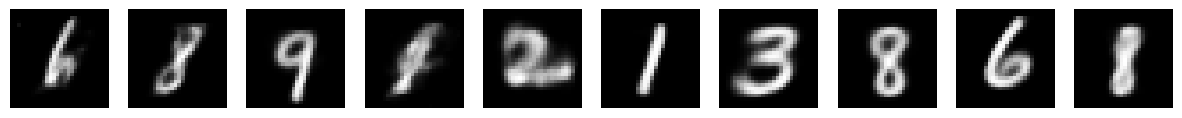

In [99]:
show_generated_images(improvedCustomVAE, latent_dim=3)

In [98]:
# Display a 2D manifold of the digits
import numpy as np
from scipy.stats import norm
n = 20  # figure with 20x20 digits
digit_size = 28

u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n), np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
z_grid = torch.tensor(z_grid, dtype=torch.float32).view(-1, 2).to(device)
x_decoded = improvedCustomVAE.decode(z_grid).cpu().detach().numpy()

# Display a 2D manifold of the digits
import matplotlib.pyplot as plt
from matplotlib import cm
figsize = 15
figure = np.zeros((digit_size * n, digit_size * n))
for i in range(n):
    for j in range(n):
        digit = x_decoded[i * n + j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(figsize, figsize))
plt.imshow(figure)
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x2 and 3x64)

In [106]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(ConvolutionalVAE, self).__init__()

        # Encodeur
        self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.rl1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.rl2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc21 = nn.Linear(128, latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(128, latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 32 * 7 * 7)
        self.cvtrans1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.rl3 = nn.ReLU()
        self.cvtrans2 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.rl1(self.conv1(x))
        h2 = self.rl2(self.conv2(h1))
        h2 = h2.view(-1, 32 * 7 * 7)
        h3 = F.relu(self.fc1(h2))
        return self.fc21(h3), self.fc22(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = F.relu(self.fc3(z))
        h5 = F.relu(self.fc4(h4)).view(-1, 32, 7, 7)
        h6 = self.rl3(self.cvtrans1(h5))
        return self.sigmoid(self.cvtrans2(h6))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Création d'une instance du modèle CustomVAE avec la nouvelle dimension latente
convolutionalVAE = ConvolutionalVAE()

# entraînement du modèle
optimizer = torch.optim.Adam(convolutionalVAE.parameters(), lr=1e-3)
for epoch in range(10):
    convolutionalVAE.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = convolutionalVAE(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')
    

Epoch 0, Loss: 196.34861186523437
Epoch 1, Loss: 163.46127976888022
Epoch 2, Loss: 158.58495224609376
Epoch 3, Loss: 156.07577770182291
Epoch 4, Loss: 154.30786025390626
Epoch 5, Loss: 153.05396531575522
Epoch 6, Loss: 152.04546416015626
Epoch 7, Loss: 151.19048670247395
Epoch 8, Loss: 150.47234991861978
Epoch 9, Loss: 149.87265203450522


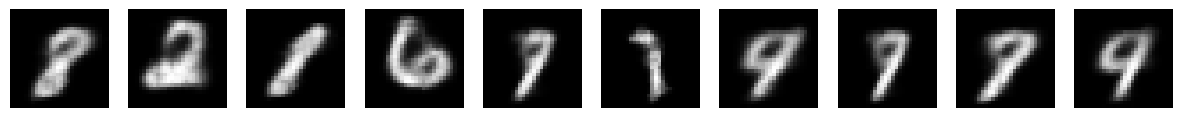

In [110]:
show_generated_images(convolutionalVAE, latent_dim=2)